<a href="https://colab.research.google.com/github/mrkdh16/lottery-ticket-exploration/blob/main/LTH_OOD_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I aim to test the functional lottery ticket hypothesis presented in [Zhang et al](https://proceedings.mlr.press/v139/zhang21a/zhang21a.pdf): "[for any full network] there exists a subnetwork that can achieve better OOD and commensurate in-distribution accuracy in a comparable number of iterations when trained in isolation" using the [MNIST-1D dataset](https://github.com/greydanus/mnist1d?tab=readme-ov-file).

Much of the code in this notebook is borrowed from an [example notebook](https://github.com/greydanus/mnist1d/blob/master/notebooks/lottery-tickets.ipynb) from the [MNIST-1D repo](https://github.com/greydanus/mnist1d?tab=readme-ov-file).

In [1]:
!python -m pip install git+https://github.com/greydanus/mnist1d.git@master
!git clone https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d.git (to revision master) to /tmp/pip-req-build-a9gcu4wn
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d.git /tmp/pip-req-build-a9gcu4wn
  Resolved https://github.com/greydanus/mnist1d.git to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mnist1d: filename=mnist1d-0.0.2.post16-py3-none-any.whl size=14665 sha256=4d70957aa5fa2deb789cee28489bfb95f393218cc83cbfc9dee7ad7801f40874
  Stored in directory: /tmp/pip-ephem-wheel-cache-lxlnedir/wheels/7e/c4/e4/1c3e9af5ba2f0004e7850f6070dc4a1c896852c8ac5ca5bb6a
Successfully built mnist1d
Cloning into 'mnist1d'...
remote: Enumerating objects: 541, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 541 (delta 67), reused 66 (delta 66), pack-reuse

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import copy

import torch, os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import random
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

# Try attaching to GPU
DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print('Using:', DEVICE)

Using: cuda


In [3]:
if True:
    # Only run this in Colab
    from google.colab import drive
    drive.mount('/content/gdrive')
    project_dir = "/content/gdrive/My Drive/Research/mnist1d/"
else:
    project_dir = './'

Mounted at /content/gdrive


In [4]:
from mnist1d.data import get_dataset, get_dataset_args, make_dataset
from mnist1d.utils import set_seed, to_pickle, from_pickle

import sys ; sys.path.append('./mnist1d/notebooks')
from train import get_model_args, train_model

In [5]:
class SparseLinear(torch.nn.Module):
  def __init__(self, x_size, y_size):
    super(SparseLinear, self).__init__()
    self.linear = torch.nn.Linear(x_size, y_size)
    param_vec = torch.cat([p.flatten() for p in self.parameters()])
    self.mask = torch.ones_like(param_vec).to(DEVICE)

  def forward(self, x, apply_mask=True):
    if apply_mask:
      self.apply_mask()
    return self.linear(x)

  def update_mask(self, new_mask):
    self.mask = new_mask
    self.apply_mask()

  def apply_mask(self):
    self.vec2param(self.param2vec())

  def param2vec(self):
    vec = torch.cat([p.flatten() for p in self.parameters()])
    return self.mask * vec

  def vec2param(self, vec):
    pointer = 0
    for param in self.parameters():
      param_len = np.cumprod(param.shape)[-1]
      new_param = vec[pointer:pointer+param_len].reshape(param.shape)
      param.data = new_param.data
      pointer += param_len

class SparseMLP(torch.nn.Module):
  def __init__(self, input_size, output_size, hidden_size=100):
    super(SparseMLP, self).__init__()
    self.linear1 = SparseLinear(input_size, hidden_size)
    self.linear2 = SparseLinear(hidden_size, hidden_size)
    self.linear3 = SparseLinear(hidden_size, output_size)
    self.layers = [self.linear1, self.linear2, self.linear3]

  def forward(self, x):
    h = torch.relu(self.linear1(x))
    h = h + torch.relu(self.linear2(h))
    h = self.linear3(h)
    return h

  def get_layer_masks(self):
    return [l.mask for l in self.layers]

  def set_layer_masks(self, new_masks):
    for i, l in enumerate(self.layers):
      l.update_mask(new_masks[i])

  def get_layer_vecs(self):
    return [l.param2vec() for l in self.layers]

  def set_layer_vecs(self, vecs):
    for i, l in enumerate(self.layers):
      l.vec2param(vecs[i])

  # find a mask, given some heuristic and desired sparsity
def get_mask(scores, percent_sparse):
  # scores: per-weight scores for determining which weights to drop
  # percent_sparse: how much to sparsify the model
  num_to_drop = int(percent_sparse * len(scores))
  ixs_to_drop = torch.sort(scores)[1][:num_to_drop] # sort from low score to high, select k with lowest score
  mask = torch.ones_like(scores)
  mask[ixs_to_drop] = 0
  return mask

In [6]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [13]:
def accuracy(model, inputs, targets):
  preds = model(inputs).argmax(-1).cpu().numpy()
  targets = targets.cpu().numpy().astype(np.float32)
  return 100*sum(preds==targets)/len(targets)

In [14]:
def train_model(dataset, model, args):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), args.learning_rate, weight_decay=args.weight_decay)

  x_train, x_test = torch.Tensor(dataset['x']), torch.Tensor(dataset['x_test'])
  y_train, y_test = torch.LongTensor(dataset['y']), torch.LongTensor(dataset['y_test'])

  model = model.to(args.device)
  x_train, x_test, y_train, y_test = [v.to(args.device) for v in [x_train, x_test, y_train, y_test]]

  results = {'checkpoints':[], 'train_losses':[], 'test_losses':[],'train_acc':[],'test_acc':[]}
  # t0 = time.time()
  for step in range(args.total_steps+1):
      bix = (step*args.batch_size)%len(x_train) # batch index
      x, y = x_train[bix:bix+args.batch_size], y_train[bix:bix+args.batch_size]

      loss = criterion(model(x), y)
      results['train_losses'].append(loss.item())
      loss.backward() ; optimizer.step() ; optimizer.zero_grad()

      if args.eval_every > 0 and step % args.eval_every == 0: # evaluate the model
          test_loss = criterion(model(x_test), y_test)
          results['test_losses'].append(test_loss.item())
          results['train_acc'].append(accuracy(model, x_train, y_train))
          results['test_acc'].append(accuracy(model, x_test, y_test))

      # if step > 0 and step % args.print_every == 0: # print out training progress
      #     t1 = time.time()
      #     print("step {}, dt {:.2f}s, train_loss {:.3e}, test_loss {:.3e}, train_acc {:.1f}, test_acc {:.1f}"
      #         .format(step, t1-t0, loss.item(), results['test_losses'][-1], \
      #                 results['train_acc'][-1], results['test_acc'][-1]))
      #     t0 = t1

      # if args.checkpoint_every > 0 and step % args.checkpoint_every == 0: # save model checkpoints
      #     model.step = step
      #     results['checkpoints'].append( copy.deepcopy(model) )
  results['checkpoints'].append(copy.deepcopy(model))
  return results

In [8]:
def find_lottery_ticket(model, dataset, args, sparsity_schedule, criteria_fn=None,
                        prune_print_every=None, seed=None, **kwargs):
  if seed is not None:
    set_seed(seed)

  if prune_print_every is None:
    prune_print_every = np.inf

  if criteria_fn is None:
    print("Using default magnitude-based pruning")
    criteria_fn = lambda init_params, final_params: final_params.abs()

  init_params = model.get_layer_vecs()
  stats = {'train_losses':[], 'test_losses':[], 'train_accs':[], 'test_accs':[]}
  models = []
  for i, percent_sparse in enumerate(sparsity_schedule):

    # layer-wise pruning, where pruning heuristic is determined by criteria_fn
    final_params = model.get_layer_vecs()
    scores = [criteria_fn(ip, fp) for ip, fp in zip(init_params, final_params)]
    masks = [get_mask(s, percent_sparse) for s in scores]

    # update model with mask and init parameters
    model.set_layer_vecs(init_params)
    model.set_layer_masks(masks)

    # training process
    results = train_model(dataset, model, args)
    model = results['checkpoints'][-1]

    # store stats
    stats['train_losses'].append(results['train_losses'])
    stats['test_losses'].append(results['test_losses'])
    stats['train_accs'].append(results['train_acc'])
    stats['test_accs'].append(results['test_acc'])

    # print progress
    if (i+1) % prune_print_every == 0:
      print('\tretrain #{}, sparsity {:.2f}, final_train_loss {:.3e}, max_acc {:.1f}, last_acc {:.1f}, mean_acc {:.1f}'
            .format(i+1, percent_sparse, results['train_losses'][-1], np.max(results['test_acc']),
            results['test_acc'][-1], np.mean(results['test_acc']) ))
      models.append(copy.deepcopy(model))

  stats = {k: np.stack(v) for k, v in stats.items()}
  return models, stats

In [16]:
# train settings
model_args = get_model_args()
model_args.total_steps = 1501
model_args.hidden_size = 500
model_args.print_every = 5000 # print never
model_args.eval_every = 100
model_args.learning_rate = 2e-2
model_args.device = DEVICE

# sparsity settings
num_retrains = 10
# sparsity_schedule = np.linspace(0,1.,num_retrains) #1-np.cumprod(np.ones(num_retrains)*tau)/tau # tau = .97
sparsity_schedule = np.linspace(0,1.,num_retrains)

In [11]:
args = get_dataset_args()
data = get_dataset(args=args)

Saving to ./mnist1d_data.pkl
Successfully loaded data from ./mnist1d_data.pkl


In [17]:
num_trials = 10
trials = {'lott_models': [], 'lott_stats': []}
for t in tqdm(range(num_trials)):
  set_seed(model_args.seed+t)
  model = SparseMLP(model_args.input_size, model_args.output_size, hidden_size=model_args.hidden_size).to(DEVICE)

  criteria_fn = lambda init_params, final_params: final_params.abs()
  models, stats = find_lottery_ticket(model, data, model_args, sparsity_schedule,
                  criteria_fn=criteria_fn, prune_print_every=1)
  trials['lott_models'].append(models)
  trials['lott_stats'].append(stats)

	retrain #1, sparsity 0.00, final_train_loss 1.197e-01, max_acc 64.4, last_acc 63.3, mean_acc 57.3
	retrain #2, sparsity 0.11, final_train_loss 3.175e-01, max_acc 66.1, last_acc 66.1, mean_acc 58.9
	retrain #3, sparsity 0.22, final_train_loss 1.947e-01, max_acc 66.6, last_acc 65.6, mean_acc 59.7
	retrain #4, sparsity 0.33, final_train_loss 5.246e-02, max_acc 67.4, last_acc 65.3, mean_acc 60.8
	retrain #5, sparsity 0.44, final_train_loss 1.889e-01, max_acc 66.9, last_acc 66.1, mean_acc 60.8
	retrain #6, sparsity 0.56, final_train_loss 6.789e-02, max_acc 68.3, last_acc 67.9, mean_acc 62.8
	retrain #7, sparsity 0.67, final_train_loss 2.596e-03, max_acc 76.6, last_acc 76.6, mean_acc 67.2
	retrain #8, sparsity 0.78, final_train_loss 1.048e-02, max_acc 74.7, last_acc 72.5, mean_acc 67.3
	retrain #9, sparsity 0.89, final_train_loss 5.137e-02, max_acc 75.2, last_acc 73.1, mean_acc 67.1
	retrain #10, sparsity 1.00, final_train_loss 2.303e+00, max_acc 10.2, last_acc 10.2, mean_acc 10.2
	retrain 

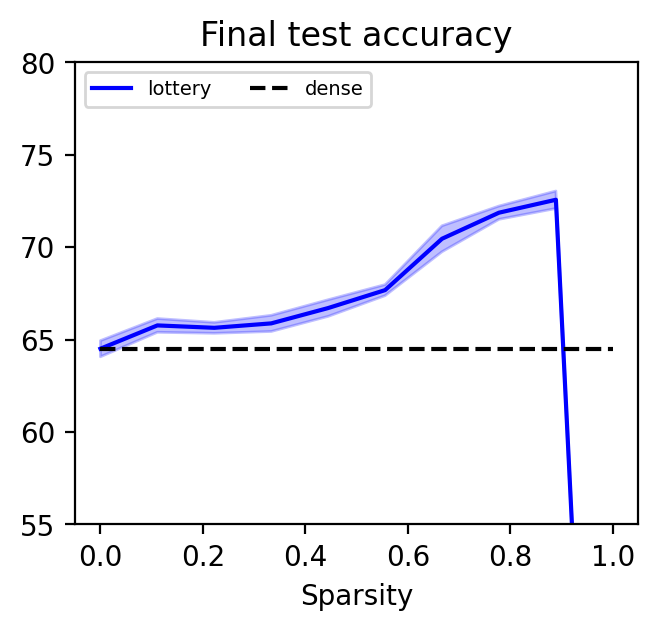

In [18]:
def average_over(trials, trial_name, key):
  ys = [trials[trial_name][i][key] for i in range(len(trials[trial_name]))]
  return np.stack(ys).mean(0), np.stack(ys).std(0) / np.sqrt(len(ys))

x = sparsity_schedule
rand_color, lott_color = 'r', 'b'
fig = plt.figure(figsize=[8,3], dpi=200)

# plt.subplot(1,2,1)
# y, y_err = average_over(trials, 'lott_stats', 'test_losses')
# y, y_err = y[:,-1], y_err[:,-1]
# plt.plot(x, y, '-', color=lott_color, label='lottery') ; plt.fill_between(x, y-y_err, y+y_err, color=lott_color, alpha=0.25)
# plt.plot(x, np.ones_like(x) * y[0], 'k--', label='dense')
# plt.xlabel('Sparsity') ; plt.title('Final test loss')
# plt.yscale('log')
# plt.ylim(None, 5e0)
# plt.legend(fontsize=7, ncol=3, loc='upper left')

plt.subplot(1,2,2)
y, y_err = average_over(trials, 'lott_stats', 'test_accs')
y, y_err = y[:,-1], y_err[:,-1]
plt.plot(x, y, '-', color=lott_color, label='lottery') ; plt.fill_between(x, y-y_err, y+y_err, color=lott_color, alpha=0.25)
plt.plot(x, np.ones_like(x) * y[0], 'k--', label='dense')
plt.xlabel('Sparsity') ; plt.title('Final test accuracy')
plt.ylim(55, 80) #plt.ylim(70, 85)
plt.legend(fontsize=7, ncol=3, loc='upper left')

# plt.subplot(1,3,3)
# y, y_err = average_over(trials, 'rand_stats', 'test_accs')
# y, y_err = y.max(-1), y_err[range(y.shape[0]),y.argmax(-1)]
# plt.plot(x, y, '-', color=rand_color, label='random') ; plt.fill_between(x, y-y_err, y+y_err, color=rand_color, alpha=0.25)
# y, y_err = average_over(trials, 'lott_stats', 'test_accs')
# y, y_err = y.max(-1), y_err[range(y.shape[0]),y.argmax(-1)]
# plt.plot(x, y, '-', color=lott_color, label='lottery') ; plt.fill_between(x, y-y_err, y+y_err, color=lott_color, alpha=0.25)
# plt.plot(x, np.ones_like(x) * y[0], 'k--', label='dense')
# plt.xlabel('Sparsity') ; plt.title('Max test accuracy')
# plt.ylim(55, 80) #plt.ylim(55, 75)
# plt.legend(fontsize=7, ncol=3, loc='upper left')

plt.show()

# os.makedirs(project_dir + 'figures/', exist_ok=True)
# fig.savefig(project_dir + 'figures/lottery.png')
# fig.savefig(project_dir + 'figures/lottery.pdf')

In [20]:
def evaluate_model(model, dataset, device):
    model.eval()
    inputs = torch.tensor(dataset['x_test'], dtype=torch.float32).to(device)
    labels = torch.tensor(dataset['y_test'], dtype=torch.int64).to(device)
    test_dataset = TensorDataset(inputs, labels)
    test_loader = DataLoader(test_dataset, batch_size=model_args.batch_size, shuffle=False)

    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = (correct_predictions / total_samples) * 100
    return {'test_loss': avg_loss, 'test_acc': accuracy}